# Titanic Survival

<img src="titanic_sinking.JPG" width="100%" alt="Header">

## Preparation

### 1. Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ydata_profiling import ProfileReport
from IPython.display import display, HTML
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import shap
import joblib
from pyod.models.knn import KNN
from IPython.display import Image, display

### 2. Import Dataset

In [5]:
DATA_DIR = os.path.join("..", "data")

df_train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test_passenger_id = df_test['PassengerId'].copy()

print("Train Shape:", df_train.shape)  
print("Test Shape:", df_test.shape)
df_train.head()

Train Shape: (891, 12)
Test Shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Data Leakage Check

In [49]:
assert 'Survived' not in df_train.drop('Survived', axis=1).columns
print("Data Leakage: OK")

Data Leakage: OK


## EDA : Exploratory Data Analysis

### 1. Profile Report

In [ ]:
profile = ProfileReport(
    df_train,
    title="Titanic Survival - EDA Report",
    explorative=True,
    correlations={
        "auto": {"calculate": True},
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
    },
    missing_diagrams={"bar": True, "matrix": True, "heatmap": True},
    interactions={"continuous": True}
)

output_file = "eda_report.html"
profile.to_file(output_file)

print(f"Report saved as: {output_file}")

display(HTML(filename=output_file))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 196.33it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Report saved as: eda_report.html


### 2. Correlation + Heatmap

In [51]:
corr = df_train.select_dtypes(include=['float64', 'int64']).corr()
fig = px.imshow(corr, text_auto=True, aspect="auto", color_continuous_scale='RdBu')
fig.update_layout(title="Correlation & Heatmap")
fig.show()

### 3. Plotly Visualization

In [52]:
fig = px.histogram(df_train, x='Age', color='Survived', nbins=30, title="Age vs Survival")
fig.show()

fig = px.bar(df_train, x='Pclass', color='Survived', barmode='group', title="Class vs Survival")
fig.show()

### 4. Feature Engineering

In [53]:
def add_features(df):
    """
    Add meaningful features to improve model performance.
    Features: FamilySize, IsAlone, Title, Deck
    """
    # Family Size: Total number of family members on board (including self)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # IsAlone: 1 if passenger is traveling alone, 0 otherwise
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Extract Title from Name (e.g., Mr, Mrs, Miss, Master)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Group rare titles into 'Rare'
    df['Title'] = df['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
    ], 'Rare')
    
    # Standardize title variations
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Extract Deck from Cabin (first letter), 'M' for missing
    df['Deck'] = df['Cabin'].astype(str).str[0]  # 'nan' -> 'n'
    df['Deck'] = df['Deck'].replace('n', 'M')    # Replace 'n' with 'M' (Missing)
    df['Deck'] = df['Deck'].fillna('M')         # Final fill for any remaining NaN
    
    return df

# Apply feature engineering to both datasets
df_train = add_features(df_train.copy())
df_test = add_features(df_test.copy())

print("Feature Engineering completed for train and test sets!")
print("New features added: FamilySize, IsAlone, Title, Deck")

Feature Engineering completed for train and test sets!
New features added: FamilySize, IsAlone, Title, Deck


## Preprocessing

### 1. Missing Value + Indicator

In [54]:
def impute_missing(df):
    # ----- Age -----
    # Indicator column (1 = originally missing, 0 = observed)
    df['Age_missing'] = df['Age'].isnull().astype(int)
    
    # Fill with median of the **training** set (leak-proof)
    age_median = df_train['Age'].median()   # compute once on train
    df['Age'] = df['Age'].fillna(age_median)
    
    # ----- Embarked -----
    # Most frequent value from **training** set
    embarked_mode = df_train['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(embarked_mode)
    
    return df


# Apply to both datasets
df_train = impute_missing(df_train.copy())
df_test  = impute_missing(df_test.copy())

print("Missing-value imputation completed!")
print("  - Age median (train):", df_train['Age'].median())
print("  - Embarked mode (train):", df_train['Embarked'].mode()[0])

Missing-value imputation completed!
  - Age median (train): 28.0
  - Embarked mode (train): S


### 2. Outlier Handling (PyOD)

In [55]:
# Select numerical features
numerical_cols = ['Age', 'Fare']
X_num = df_train[numerical_cols]

# Fit KNN detector and predict outliers
detector = KNN()
outliers = detector.fit_predict(X_num)

# Keep only inliers (0 = normal, 1 = outlier)
df_train = df_train[outliers == 0].reset_index(drop=True)

print(f"Removed {sum(outliers)} outliers from training set")
print(f"Train shape after outlier removal: {df_train.shape}")

Removed 89 outliers from training set
Train shape after outlier removal: (802, 17)


### 3. Encoding & Scaling

In [56]:
# Features and target
X = df_train.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df_train['Survived']

# Categorical and numerical columns
cat_cols = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
num_cols = ['Age', 'Fare', 'FamilySize', 'IsAlone', 'Age_missing']

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

### 4. Train/Test Split + Stratify

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set: {X_train.shape} → for model training")
print(f"Validation set: {X_val.shape} → for internal evaluation")

Train set: (641, 12) → for model training
Validation set: (161, 12) → for internal evaluation


### 5. Imbalanced? SMOTE

In [58]:
def apply_smote(X, y, preprocessor, random_state=42):
    
    smote_pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=random_state))
    ])
    
    X_bal, y_bal = smote_pipe.fit_resample(X, y)
    
    return X_bal, y_bal

print("SMOTE function ready! it Uses After Grid Search")

SMOTE function ready! it Uses After Grid Search


## Modeling

### 1. Select Model (XGBoost)

In [59]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False
    ))
])

### 2. Cross Validation

In [60]:
scores = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='accuracy')

### 3. Grid Search for Hyperparameter Tuning

In [61]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

print("Running GridSearch on raw (imbalanced) data...")

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best CV Accuracy (on raw): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Running GridSearch on raw (imbalanced) data...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV Accuracy (on raw): 0.8471


### 4. Final Training

In [62]:
final_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        **grid_search.best_params_
    ))
])

final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare', 'FamilySize',
                                                   'IsAlone', 'Age_missing']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title', 'Deck'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=Non...
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, ...))])

## Evaluation

### 1. Confusion Matrix + Report

In [63]:
y_val_pred = final_model.predict(X_val)

print("=== Classification Report (Validation Set) ===")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'], 
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

=== Classification Report (Validation Set) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       103
           1       1.00      0.95      0.97        58

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161

Validation Accuracy: 0.9814


### 2. SHAP Feature Importance Analysis

1. SHAP Feature Importance:


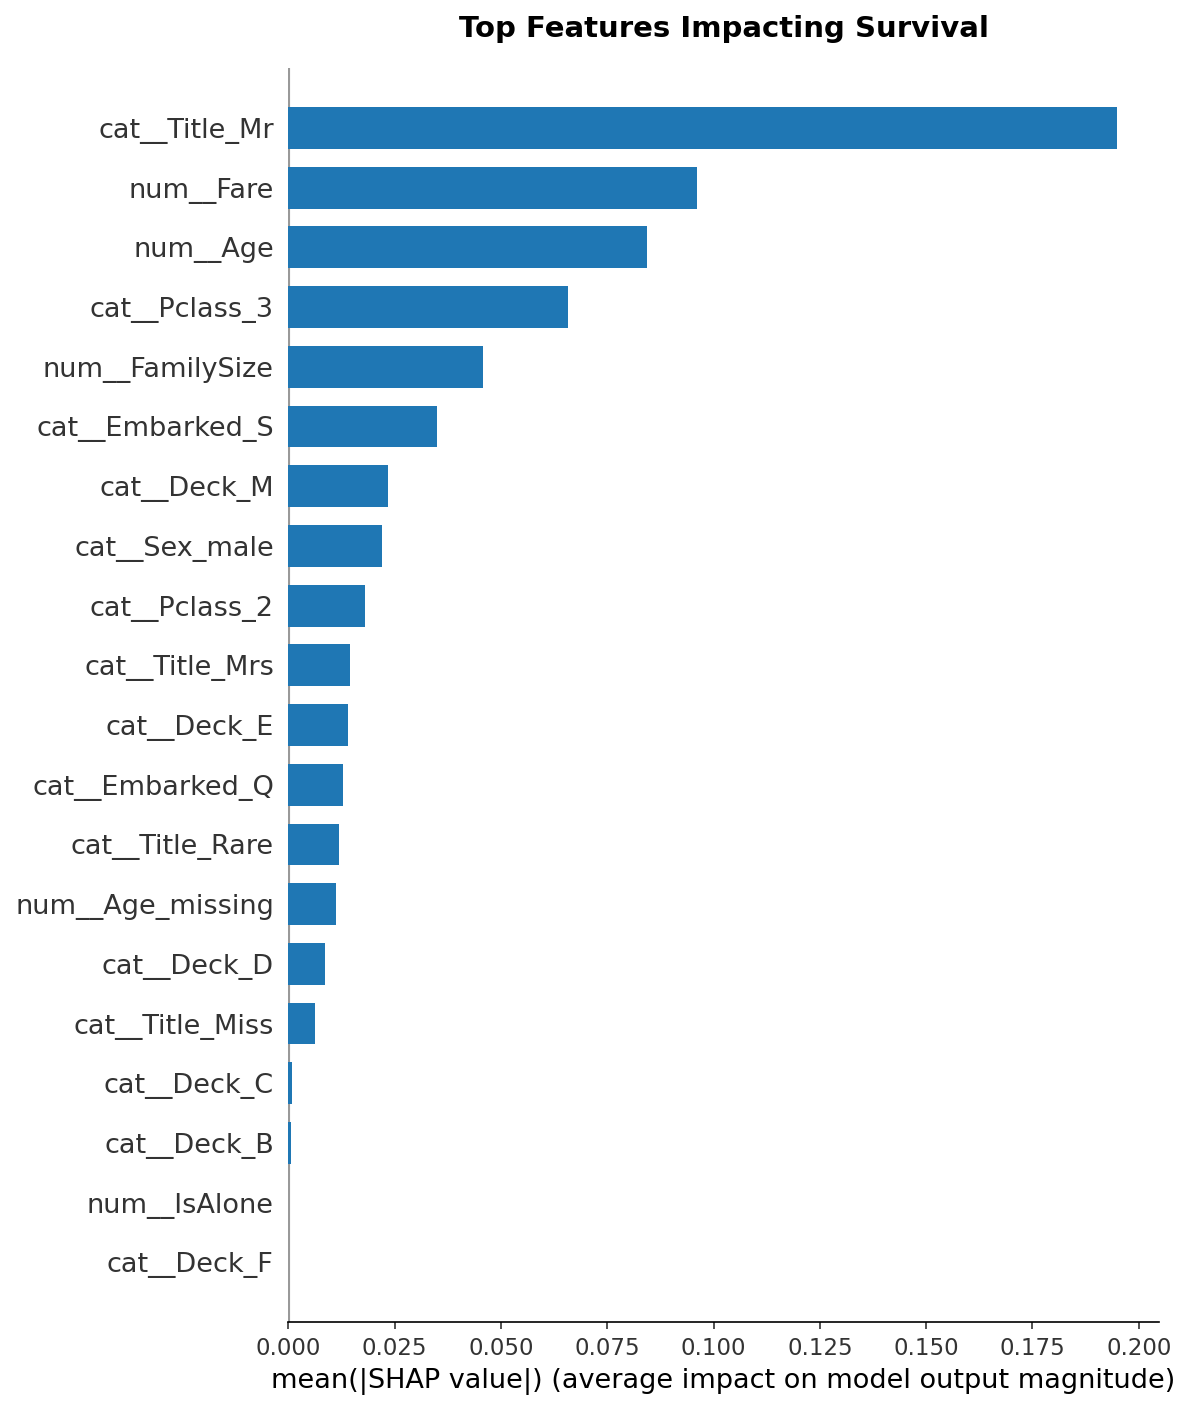


2. SHAP Summary Plot (Red = Higher Survival, Blue = Lower):


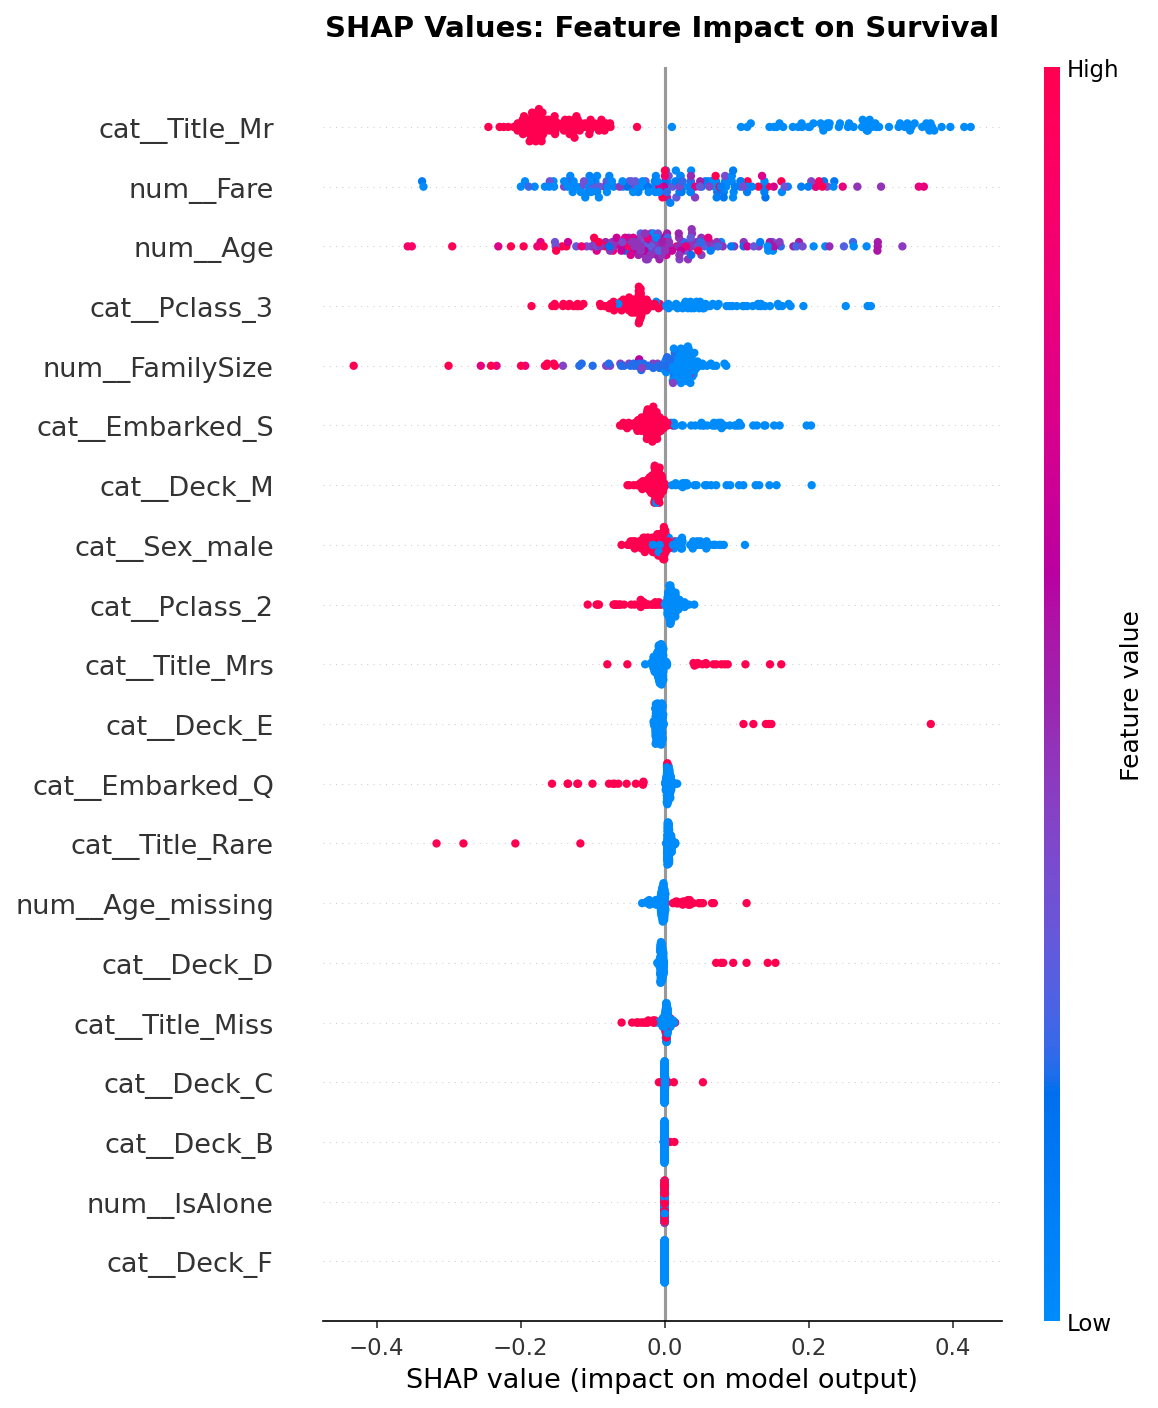

In [64]:
# Transform validation data
X_val_processed = preprocessor.transform(X_val)

# Extract trained XGBoost model
model = final_model.named_steps['classifier']

# Prediction function: probability of survival
def predict_fn(X):
    return model.predict_proba(X)[:, 1]

# Initialize SHAP Explainer
explainer = shap.Explainer(
    predict_fn,
    X_val_processed,
    feature_names=preprocessor.get_feature_names_out()
)
shap_values = explainer(X_val_processed)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# === 1. Feature Importance (Bar Plot) ===
plt.figure(figsize=(8, 5))  # Smaller size
shap.summary_plot(
    shap_values,
    X_val_processed,
    feature_names=feature_names,
    plot_type="bar",
    color="#1f77b4",
    show=False
)
plt.title("Top Features Impacting Survival", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=150, bbox_inches='tight')
plt.close()

# === 2. SHAP Summary (Impact Direction) ===
plt.figure(figsize=(8, 6))  # Slightly taller for beeswarm
shap.summary_plot(
    shap_values,
    X_val_processed,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Values: Feature Impact on Survival", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=150, bbox_inches='tight')
plt.close()

# === Display both images in notebook ===
print("1. SHAP Feature Importance:")
display(Image("shap_feature_importance.png", width=700))  # Smaller display

print("\n2. SHAP Summary Plot (Red = Higher Survival, Blue = Lower):")
display(Image("shap_summary_plot.png", width=700))

## Output

### 1. Model Saving

In [ ]:
os.makedirs("models", exist_ok=True)

joblib.dump(final_model, "models/titanic_final.pkl")
joblib.dump(preprocessor, "models/preprocessor.pkl")

print("Model & Preprocessor Saved!")

Model & Preprocessor Saved!


### 2. submission for Kaggle

In [66]:
# === Use ONLY preprocessor + trained classifier (NO SMOTE) ===
# Extract the trained XGBoost model (already fitted on SMOTE data)
trained_classifier = final_model.named_steps['classifier']

# Transform test data using ONLY the preprocessor
X_test_processed = preprocessor.transform(
    df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')
)

# Predict using the trained classifier directly
test_predictions = trained_classifier.predict(X_test_processed)

# Create submission
submission = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")
print(f"Shape: {submission.shape}")
submission.head()

submission.csv created successfully!
Shape: (418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
